In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import platform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'cuda version: {torch.version.cuda}')
print(f'Python version: {platform.python_version()}')

Pytorch version: 2.4.1
cuda version: None
Python version: 3.10.14


In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load data and normalize

### Normalization


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Normalization adjusts the values of the image tensors using the following formula:

 $X_{normalized}$ = $\frac{X - \mu}{\sigma}$


where:

- X is the value of each pixel in the image.
- is the mean of the pixel values, which in this case is 0.5.
- σ is the standard deviation, also 0.5 in this case.

shifts the values to the range [-1, 1].

### Data splitting and more

In [5]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
print("Training size:", len(train_dataset))
print("Test size:", len(test_dataset))

Training size: 60000
Test size: 10000


In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

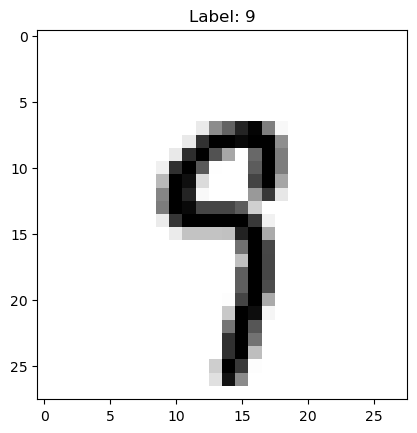

In [8]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [9]:
images[0].shape

torch.Size([1, 28, 28])

In [10]:
images[0].unique()

tensor([-1.0000, -0.9922, -0.9843, -0.9529, -0.9451, -0.9216, -0.8902, -0.8824,
        -0.8431, -0.8353, -0.8275, -0.8118, -0.7569, -0.7176, -0.6314, -0.6157,
        -0.5686, -0.5294, -0.5137, -0.5059, -0.4902, -0.4510, -0.3333, -0.3098,
        -0.2941, -0.2000, -0.1137, -0.0980, -0.0902, -0.0431,  0.0039,  0.0118,
         0.0196,  0.0745,  0.0902,  0.0980,  0.1765,  0.2157,  0.2549,  0.2706,
         0.2863,  0.3176,  0.3412,  0.3961,  0.4353,  0.4431,  0.4510,  0.4588,
         0.5373,  0.5451,  0.5765,  0.6000,  0.6078,  0.6392,  0.7098,  0.7176,
         0.8431,  0.8745,  0.8902,  0.9137,  0.9608,  0.9843,  0.9922])

# $LeNet$-$5$ <span style="color:MediumSeaGreen">_Architecture_</span>


<img title="a title" alt="Alt text" src="images/architecture_LeNet-5.png">


LeNet-5 consists of seven layers (not counting input) with three main types of layers: convolutional layers, subsampling (pooling) layers, and fully connected layers. The model takes a 32x32 grayscale input image and produces an output with 10 classes, corresponding to the digits 0 through 9. Here’s the sequential breakdown of each layer:



### <span style="color:DodgerBlue">1. Input layer</span>
The input is a 32x32 pixel image, but in the MNIST data the images are 28x28. We need to resize the images using the normalization shown before and store it as a tensor.

### <span style="color:DodgerBlue">2. C1: First Convolutional Layer</span>

This layer performs convolution using 6 filters of size 5x5 across the input image, producing six 28x28 feature maps. Each filter extracts different local features like edges and corners.

- **Feature Maps:** 6

- **Connections:** Each unit is fully connected to C5
- **Stride:** 1 
- **Padding:** None (the layer is a "valid" convolution, reducing the image size)
- **Output Size:** 28 x 28 x 6 (since the input is 32x32 and applying a 5x5 filter reduces each dimension by 4, yielding 28x28)
- **Activation:** Sigmoid (in the original architecture, in modern implementations often use ReLU)
- **Trainable parameters:** 156 (weight + bias = 5 x 5 x 1 x 6 + 6)
- **Connections:** 122,304 (28 x 28 x 156)


### <span style="color:DodgerBlue">3. S2: First Subsampling (Pooling) Layer</span>

This layer reduces the spatial dimensions of each of the 6 feature maps from 28x28 to 14x14 using 2x2 average pooling. Pooling helps reduce the computational load, extract dominant features, and introduces some degree of translation invariance.

- **Feature Maps:** 6

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 14 x 14 x 6
- **Activation:** None. Performs subsampling directly on the input.
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 6)
- **Conections:** 5,880 (14 x 14 x 30)


### <span style="color:DodgerBlue">4. C3: Second Convolutional Layer</span>

This layer applies 16 filters of size 5x5. Each of these filters is connected to all six feature maps from the previous layer in a complex connectivity pattern (Table I shows the set of S2 feature maps). This design choice was meant to increase the variety of patterns learned by the network.

<img title="a title" alt="Alt text" src="images/S2.png" width=600>

- **Feature Maps:** 16

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 10 x 10 x 16
- **Activation:** Sigmoid
- **Trainable parameters:** 1,516 (weight + bias = (5 x 5 x 6 x 10) + 16)
- **Conections:** 151,600 (10 x 10 x 1516)


### <span style="color:DodgerBlue">5. S4: Second Subsampling (Pooling) Layer</span>

Similar to S2, this layer reduces the spatial dimensions of the 16 feature maps from 10x10 to 5x5 using 2x2 average pooling.

- **Feature Maps:** 16

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 5 x 5 x 16
- **Activation:** None
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 16)
- **Conections:** 2,000 (5 x 5 x 80)


### <span style="color:DodgerBlue">6. C5: Third Convolutional Layer (Fully Connected Convolutional Layer)</span>

This layer is technically a convolutional layer but functions as a fully connected layer since the filter size matches the input dimension (5x5). The 120 filters create a single output for each, resulting in a 1x1x120 output.

- **Feature Maps:** 120

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Sigmoid
- **Trainable parameters:** 48,120 (weight + bias = (400 x 120) + 120)
- **Conections:** 48,120

### <span style="color:DodgerBlue">7. F6: Fully Connected Layer</span>

his layer has 84 neurons, each fully connected to the 120-element input vector. This part of the network is similar to a traditional multi-layer perceptron, serving to combine the extracted features from previous layers to make predictions.

- **Units:** 84

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Uses a scaled hyperbolic tangent function $f(a) = A 
*tanh(Sa)$
- **Trainable parameters:** 10,164 (weight + bias = (120 x 84) + 84)
- **Conections:** 10,164


### <span style="color:DodgerBlue">8. Output Layer</span>

he final layer has 10 neurons, each corresponding to one of the digit classes (0-9). This layer produces the network's output, a probability distribution over the 10 classes, using the softmax function.

 **Units:** 10

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:**  Euclidean Radial Basis Function units (RBF)

Each RBF unit $y_i$ is computed as follow: 

$y_i = \sum_{j} (x_j - w_{ij})^2$  

Modern versions use Softmax


In [11]:
# LeNet-5 (original architecture)
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # C1: Convolutional Layer - Input: 1x32x32, Output: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # S2: Subsampling (Average Pooling) Layer - Input: 6x28x28, Output: 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C3: Convolutional Layer - Input: 6x14x14, Output: 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # S4: Subsampling (Average Pooling) Layer - Input: 16x10x10, Output: 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C5: Fully Connected Convolutional Layer - Input: 16x5x5, Output: 120x1x1
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        # F6: Fully Connected Layer - Input: 120, Output: 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # Output Layer - Input: 84, Output: 10
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # C1 ->  activation
        x = torch.relu(self.conv1(x))
        #print(f"After conv1: {x.shape}")
        # S2: Average Pooling
        x = self.pool1(x)
        #print(f"After pool1: {x.shape}")
        # C3 ->  activation
        x = torch.relu(self.conv2(x))
        #print(f"After conv2: {x.shape}")
        # S4: Average Pooling
        x = self.pool2(x)
        #print(f"After pool2: {x.shape}")
        # Flatten the tensor for the fully connected layer
        # x = x.view(-1, 16*5*5)
        x = x.view(x.size(0), -1)
        #print(f"After flattening: {x.shape}")
        # C5 
        x = torch.relu(self.fc1(x))
        #print(f"After fc1: {x.shape}")
        # F6 
        x = torch.relu(self.fc2(x))
        #print(f"After fc1: {x.shape}")
        # Output layer
        x = self.fc3(x)
        # x = torch.softmax(x,dim=1)
        
        return x


# Architecture 2: LeNet-5 with one convolutional layer removed
class LeNet5_OneConv(nn.Module):
    def __init__(self):
        super(LeNet5_OneConv, self).__init__()
        # C1: Convolutional Layer - Input: 1x32x32, Output: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # S2: Subsampling (Average Pooling) Layer - Input: 6x28x28, Output: 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C5: Fully Connected Convolutional Layer - Input: 16x5x5, Output: 120x1x1
        self.fc1 = nn.Linear(in_features=6*14*14, out_features=120)
        # F6: Fully Connected Layer - Input: 120, Output: 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # Output Layer - Input: 84, Output: 10
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # C1 ->  activation
        x = torch.relu(self.conv1(x))
        #print(f"After conv1: {x.shape}")
        # S2: Average Pooling
        x = self.pool1(x)
        #print(f"After pool1: {x.shape}")
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        #print(f"After flattening: {x.shape}")
        # C5 
        x = torch.relu(self.fc1(x))
        #print(f"After fc1: {x.shape}")
        # F6 
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")
        # Output layer
        x = self.fc3(x)
        # x = torch.softmax(x,dim=1)
        
        return x



# Architecture 3: LeNet-5 with an additional convolutional layer
class LeNet5_ExtraConv(nn.Module):
    def __init__(self):
        super(LeNet5_ExtraConv, self).__init__()
        # C1: Convolutional Layer - Input: 1x32x32, Output: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # S2: Subsampling (Average Pooling) Layer - Input: 6x28x28, Output: 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C3: Convolutional Layer - Input: 6x14x14, Output: 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # S4: Subsampling (Average Pooling) Layer - Input: 16x10x10, Output: 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C4: Convolutional Layer - Input: , Output: 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        # S5: Subsampling (Average Pooling) Layer - Input: , Output: 
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C6: Fully Connected Convolutional Layer - Input: 16x5x5, Output: 120x1x1
        self.fc1 = nn.Linear(in_features=32*1*1, out_features=120)
        # F7: Fully Connected Layer - Input: 120, Output: 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # Output Layer - Input: 84, Output: 10
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # C1 ->  activation
        x = torch.relu(self.conv1(x))
        # print(f"After conv1: {x.shape}")
        # S2: Average Pooling
        x = self.pool1(x)
        #print(f"After pool1: {x.shape}")
        # C3 ->  activation
        x = torch.relu(self.conv2(x))
        #print(f"After conv2: {x.shape}")
        # S4: Average Pooling
        x = self.pool2(x)
        #print(f"After pool2: {x.shape}")
        # C5 ->  activation
        x = torch.relu(self.conv3(x))
        #print(f"After conv3: {x.shape}")
        # S6: Average Pooling
        x = self.pool3(x)
        #print(f"After pool3: {x.shape}")
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        #print(f"After flattening: {x.shape}")
        # C7 
        x = torch.relu(self.fc1(x))
        #print(f"After fc1: {x.shape}")
        # F8 
        x = torch.relu(self.fc2(x))
        #print(f"After fc1: {x.shape}")
        # Output layer
        x = self.fc3(x)
        # x = torch.softmax(x,dim=1)
        
        return x



lenet5 = LeNet5()
print(lenet5)

lenet5_oneconv = LeNet5_OneConv()
print(lenet5_oneconv)

lenet5_oneconv = LeNet5_OneConv()
print(lenet5_oneconv)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
LeNet5_OneConv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
LeNet5_OneConv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Line

In [12]:
# Function to train the model and compute accuracy
def train_model(model, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            #print(images[0].shape)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track training loss
            train_loss += loss.item()
            
            # Calculate the number of correct predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss_list.append(train_loss / len(train_loader))
        train_accuracy_list.append(100 * correct_train / total_train)
        
        # Testing the model after each epoch
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Track test loss
                test_loss += loss.item()
                
                # Calculate accuracy during testing
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # Calculate average test loss and accuracy
        test_loss_list.append(test_loss / len(test_loader))
        test_accuracy_list.append(100 * correct_test / total_test)
        
        # Print epoch results (optional)
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss_list[-1]:.4f}, '
              f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
              f'Test Loss: {test_loss_list[-1]:.4f}, '
              f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')
    
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list


# Setting device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
lenet5_model = LeNet5()
lenet5_oneconv_model = LeNet5_OneConv()
lenet5_extraconv_model = LeNet5_ExtraConv()


print("LeNet-5")
train_loss_base, test_loss_base, train_acc_base, test_acc_base = train_model(lenet5_model)
print("\nLeNet-5 with one convolutional layer removed")
train_loss_oneconv, test_loss_oneconv, train_acc_oneconv, test_acc_oneconv = train_model(lenet5_oneconv_model)
print("\nLeNet-5 with extra convolutional layer")
train_loss_extraconv, test_loss_extraconv, train_acc_extraconv, test_acc_extraconv = train_model(lenet5_extraconv_model)

LeNet-5
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Si

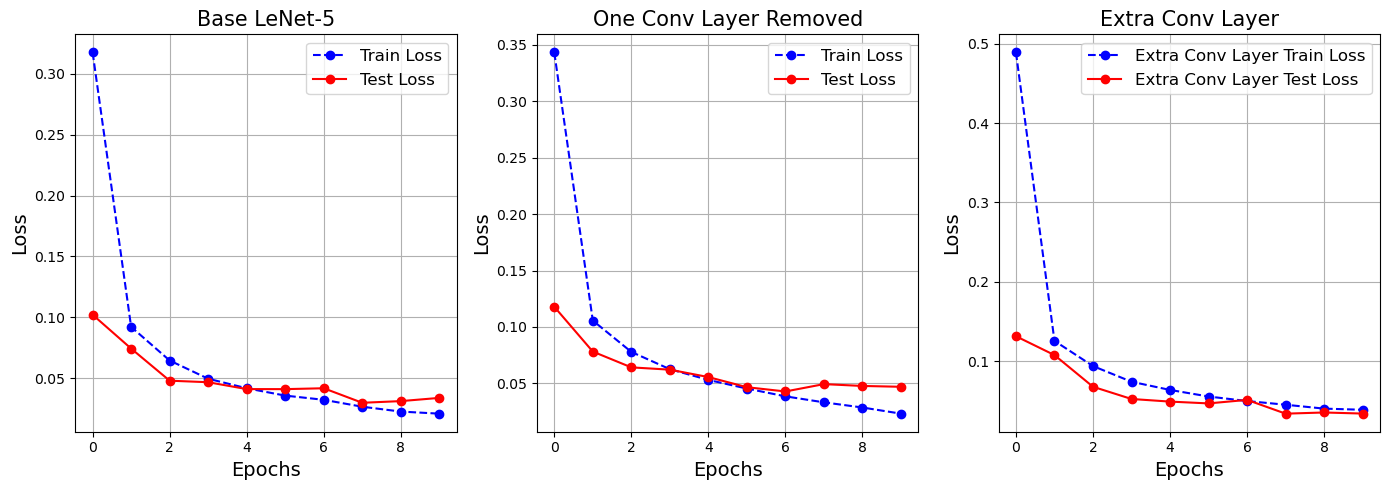

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Aquí, por ejemplo, 14 pulgadas de ancho y 10 de alto

# LeNet-5 (primer subgráfico)
axs[0].plot(train_loss_base, label='Train Loss', linestyle='--', marker='o', color='blue')
axs[0].plot(test_loss_base, label='Test Loss', linestyle='-', marker='o', color='red')
axs[0].set_title('Base LeNet-5', fontsize=15)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# LeNet-5 con una capa conv removida (segundo subgráfico)
axs[1].plot(train_loss_oneconv, label='Train Loss', linestyle='--', marker='o', color='blue')
axs[1].plot(test_loss_oneconv, label='Test Loss', linestyle='-', marker='o', color='red')
axs[1].set_title('One Conv Layer Removed', fontsize=15)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# LeNet-5 con una capa conv extra (tercer subgráfico)
axs[2].plot(train_loss_extraconv, label='Extra Conv Layer Train Loss', linestyle='--', marker='o', color='blue')
axs[2].plot(test_loss_extraconv, label='Extra Conv Layer Test Loss', linestyle='-', marker='o', color='red')
axs[2].set_title('Extra Conv Layer', fontsize=15)
axs[2].set_xlabel('Epochs', fontsize=14)
axs[2].set_ylabel('Loss', fontsize=14)
axs[2].legend(fontsize=12)
axs[2].grid(True)


# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

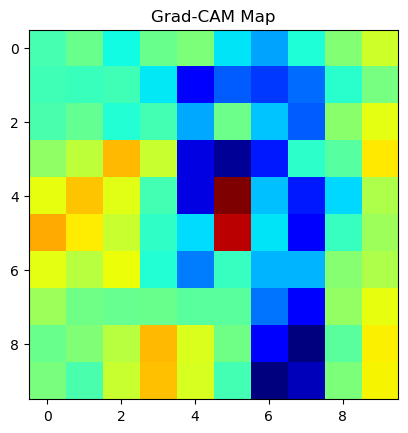

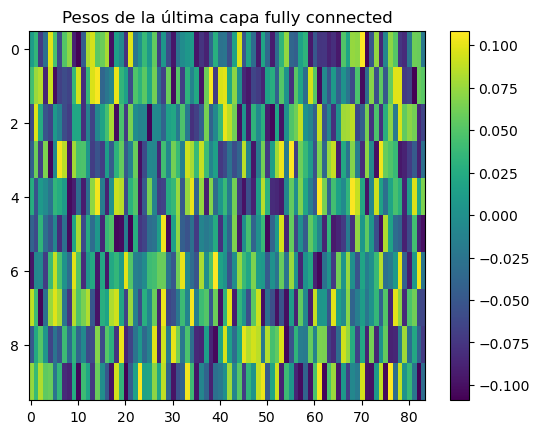

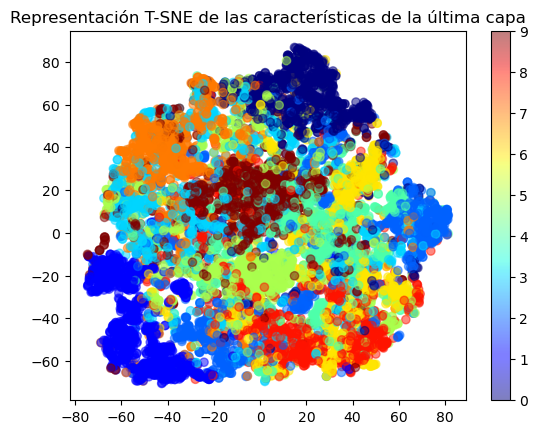

In [20]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 4. Grad-CAM para visualizar activaciones
# Grad-CAM para visualizar activaciones
def grad_cam(model, x, target_class):
    model.eval()
    activations = []
    gradients = []

    # Hook para capturar las activaciones
    def forward_hook(module, input, output):
        activations.append(output)
    
    # Hook para capturar los gradientes
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    
    # Hook para la última capa convolucional
    model.conv2.register_forward_hook(forward_hook)
    model.conv2.register_backward_hook(backward_hook)

    # Forward Pass
    output = model(x)

    # Calcular gradiente de la clase objetivo
    model.zero_grad()
    one_hot_output = torch.zeros((1, output.size()[-1]), device=x.device)
    one_hot_output[0][target_class] = 1
    output.backward(gradient=one_hot_output)

    # Obtener gradientes y activaciones
    gradient = gradients[0]  # Gradientes de la activación
    activation = activations[0].squeeze(0)

    # Calcular la importancia de cada canal
    weights = torch.mean(gradient, dim=(2, 3), keepdim=True)

    # Crear el mapa de calor ponderado
    grad_cam_map = torch.sum(weights * activation, dim=0).cpu().detach().numpy()
    grad_cam_map = np.maximum(grad_cam_map, 0)  # ReLU

    # Normalizar para visualización
    grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min())

    # Promediar a lo largo de los canales si es necesario (para asegurar un mapa 2D)
    if len(grad_cam_map.shape) == 3:
        grad_cam_map = np.mean(grad_cam_map, axis=0)

    return grad_cam_map


# 5. Visualización de los pesos de la última capa fully connected
def visualize_last_layer_weights(model):
    last_layer_weights = model.fc3.weight.data.cpu().numpy()
    plt.imshow(last_layer_weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Pesos de la última capa fully connected')
    plt.show()

# 6. Extracción de características para T-SNE
def extract_features(model, loader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = model(x)
            features.append(output.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

# 7. Visualización con T-SNE
def visualize_tsne(model, test_loader, device):
    features, labels = extract_features(model, test_loader, device)
    tsne = TSNE(n_components=2)
    tsne_features = tsne.fit_transform(features)
    
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.title('Representación T-SNE de las características de la última capa')
    plt.show()

# Ejemplo de uso
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

# Obtener una imagen de entrada y su clase objetivo para Grad-CAM
x = images[0].unsqueeze(0).to(device)  # Tomamos una imagen del batch y la ajustamos para el modelo
target_class = labels[0].item()  # Obtenemos la clase objetivo de la imagen

# Grad-CAM para una imagen específica
grad_cam_map = grad_cam(model, x, target_class)
plt.imshow(grad_cam_map, cmap='jet')
plt.title('Grad-CAM Map')
plt.show()

# Visualizar pesos de la última capa
visualize_last_layer_weights(model)

# Visualizar T-SNE
visualize_tsne(model, test_loader, device)